# CaBi ML fitting - Random Forest

Trying out Random Forest here since it seems so good in terms of minimizing prediction error.

Using RandomizedSearchCV and GridSearchCV for hyperparameter tuning.

For now, not using PolynomialFeatures for transformation because (1) results are fairly good already and (2) computational speed is a bottleneck.

## 0. Data load, shaping, and split
* Read in data from AWS
* Encode time variable (day_of_year) as cyclical
* Split into Xtrain, Xtest, ytrain, ytest based on date
  * Specify feature and target columns

In [1]:
# Read in data from AWS

from util_functions import *
import numpy as np
import pandas as pd
from pprint import pprint
import time

start_time = time.perf_counter()

set_env_path()
conn, cur = aws_connect()

# fullquery contains pretty much everything

fullquery = """
SELECT 
EXTRACT(DOY FROM date) as day_of_year,
date,
year,
quarter,
month,
day_of_week,
daylight_hours,
apparenttemperaturehigh,
apparenttemperaturehightime,
apparenttemperaturelow,
apparenttemperaturelowtime,
precipintensitymaxtime,
sunrisetime,
sunsettime,
cloudcover,
dewpoint,
humidity,
precipaccumulation,
precipintensitymax,
precipprobability,
rain,
snow,
visibility,
windspeed,
us_holiday,
nats_single,
nats_double,
nats_attendance,
dc_bike_event,
dc_pop,
cabi_bikes_avail,
cabi_stations_alx,
cabi_stations_arl,
cabi_stations_ffx,
cabi_stations_mcn,
cabi_stations_mcs,
cabi_stations_wdc,
cabi_docks_alx,
cabi_docks_arl,
cabi_docks_ffx,
cabi_docks_mcn,
cabi_docks_mcs,
cabi_docks_wdc,
cabi_stations_tot,
cabi_docks_tot,
cabi_dur_empty_wdc,
cabi_dur_full_wdc,
cabi_dur_empty_arl,
cabi_dur_full_arl,
cabi_dur_full_alx,
cabi_dur_empty_alx,
cabi_dur_empty_mcs,
cabi_dur_full_mcs,
cabi_dur_full_mcn,
cabi_dur_empty_mcn,
cabi_dur_full_ffx,
cabi_dur_empty_ffx,
cabi_dur_empty_tot,
cabi_dur_full_tot,
cabi_active_members_day_key,
cabi_active_members_monthly,
cabi_active_members_annual,
cabi_trips_wdc_to_wdc,
cabi_trips_wdc_to_wdc_casual
from final_db"""

query = """
SELECT 
EXTRACT(DOY FROM date) as day_of_year,
date,
year,
month,
day_of_week,
daylight_hours,
apparenttemperaturehigh,
apparenttemperaturehightime,
apparenttemperaturelow,
apparenttemperaturelowtime,
precipintensitymaxtime,
cloudcover,
dewpoint,
humidity,
precipaccumulation,
precipintensitymax,
precipprobability,
rain,
snow,
visibility,
windspeed,
us_holiday,
nats_single,
nats_double,
nats_attendance,
dc_bike_event,
dc_pop,
cabi_stations_tot,
cabi_docks_tot,
cabi_active_members_day_key,
cabi_active_members_monthly,
cabi_active_members_annual,
cabi_trips_wdc_to_wdc,
cabi_trips_wdc_to_wdc_casual
from final_db"""

pd.options.display.max_rows = None
pd.options.display.max_columns = None

df = pd.read_sql(query, con=conn)

# Setting date to index for easier splitting
df.set_index(df.date, drop=True, inplace=True)
df.index = pd.to_datetime(df.index)

print("We have {} instances and {} features".format(*df.shape))

We have 2780 instances and 34 features


#### Summary statistics

In [2]:
df.describe(percentiles=[.5]).round(3).transpose()

,count,mean,std,min,50%,max
day_of_year,2780.0,182.697,107.702,1.000,182.000,366.000
year,2780.0,2014.024,2.228,2010.000,2014.000,2018.000
month,2780.0,6.507,3.522,1.000,7.000,12.000
day_of_week,2780.0,2.999,2.000,0.000,3.000,6.000
daylight_hours,2780.0,12.077,2.021,9.000,12.000,15.000
apparenttemperaturehigh,2780.0,64.306,20.594,2.240,65.890,113.670
apparenttemperaturehightime,2780.0,15.460,2.352,7.000,16.000,19.000
apparenttemperaturelow,2780.0,48.574,19.685,-10.840,50.885,90.060
apparenttemperaturelowtime,2780.0,6.783,4.354,0.000,6.000,23.000
precipintensitymaxtime,2780.0,15.219,6.569,0.000,19.000,23.000


#### Which feature pairs are highly correlated?

In [3]:
def print_highly_correlated(df, features, threshold=0.75):
    """ 
    Prints highly correlated feature pairs in df. Threshold set at 0.75 by default.
    Selects pairs where abs(r) is above the threshold, puts them in a DataFrame,
    making sure to avoid duplication, then sorts by abs(r) and prints.
    """
    corr_df = df[features].corr()
    correlated_features = np.where(np.abs(corr_df) > threshold)
    correlated_features = [(corr_df.iloc[x,y], x, y) for x, y in zip(*correlated_features) if x != y and x < y]
    s_corr_list = sorted(correlated_features, key=lambda x: -abs(x[0]))
    print("There are {} feature pairs with pairwise correlation above {}".format(len(s_corr_list), threshold))
    for v, i, j in s_corr_list:
        cols = df[features].columns
        print("{} and {} = {:0.3f}".format(corr_df.index[i], corr_df.columns[j], v))
        
print_highly_correlated(df, df.columns)

There are 22 feature pairs with pairwise correlation above 0.75
cabi_stations_tot and cabi_docks_tot = 1.000
day_of_year and month = 0.997
dc_pop and cabi_docks_tot = 0.988
dc_pop and cabi_stations_tot = 0.986
year and cabi_docks_tot = 0.984
year and dc_pop = 0.983
year and cabi_stations_tot = 0.981
dc_pop and cabi_active_members_annual = 0.978
cabi_docks_tot and cabi_active_members_annual = 0.960
cabi_stations_tot and cabi_active_members_annual = 0.958
year and cabi_active_members_annual = 0.943
apparenttemperaturehigh and apparenttemperaturelow = 0.936
apparenttemperaturelow and dewpoint = 0.928
apparenttemperaturehigh and dewpoint = 0.924
year and cabi_active_members_day_key = 0.922
nats_single and nats_attendance = 0.914
cabi_docks_tot and cabi_active_members_day_key = 0.913
cabi_stations_tot and cabi_active_members_day_key = 0.910
dc_pop and cabi_active_members_day_key = 0.882
daylight_hours and cabi_active_members_monthly = 0.839
cabi_active_members_day_key and cabi_active_member

#### Encode day of year as cyclical

In [4]:
df['sin_day_of_year'] = np.sin(2*np.pi*df.day_of_year/365)
df['cos_day_of_year'] = np.cos(2*np.pi*df.day_of_year/365)

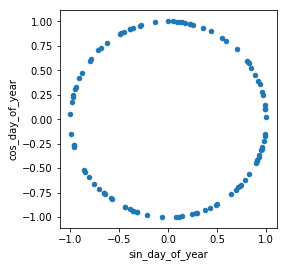

In [5]:
%matplotlib inline

df.sample(100).plot.scatter('sin_day_of_year','cos_day_of_year').set_aspect('equal')

#### Train/test split based on date
* Training dates = 2013-01-01 to 2016-12-31
* Test dates = 2017-01-01 to 2017-09-08
* New data (coincides with beginning of dockless pilot) = 2017-09-09 to present

In [6]:
# This can be tweaked, but we use ultimately use 5-fold cross-validation to pick the model

train = df.loc['2013-01-01':'2016-12-31']
test = df.loc['2017-01-01':'2017-09-08']
print(train.shape, test.shape)

tr = train.shape[0]
te = test.shape[0]
trpct = tr/(tr+te)
tepct = te/(tr+te)

print("{:0.3f} percent of the data is in the training set and {:0.3f} percent is in the test set".format(trpct, tepct))

(1461, 36) (251, 36)
0.853 percent of the data is in the training set and 0.147 percent is in the test set


In [7]:
# Specify columns to keep and drop for X and y

drop_cols = ['date']
y_cols = ['cabi_trips_wdc_to_wdc', 'cabi_trips_wdc_to_wdc_casual']

feature_cols = [col for col in df.columns if (col not in y_cols) & (col not in drop_cols)]

# X y split
Xtrain_raw = train[feature_cols]

# Our target variable here is all DC to DC trips
ytrain = train[y_cols[0]]
Xtest_raw = test[feature_cols]
ytest = test[y_cols[0]]
print(Xtrain_raw.shape, ytrain.shape, Xtest_raw.shape, ytest.shape)

(1461, 33) (1461,) (251, 33) (251,)


## 1. Preprocessing

Trying it without any preprocessing first, but keeping PolynomialFeatures here in case we use it later.

In [8]:
from sklearn.preprocessing import PolynomialFeatures

'''This cell does nothing with PF(1), but will be useful for introducing PF'''

pf = PolynomialFeatures(1, include_bias=False)

Xtrain_pf_array = pf.fit_transform(Xtrain_raw)
Xtest_pf_array = pf.transform(Xtest_raw)

# Get feature names 
Xtrain_cols = pf.get_feature_names(Xtrain_raw.columns)

# Convert arrays to dfs with the new pf column names
Xtrain = pd.DataFrame(Xtrain_pf_array, columns=Xtrain_cols)
Xtest = pd.DataFrame(Xtest_pf_array, columns=Xtrain_cols)

print(Xtrain.shape, Xtest.shape)

(1461, 33) (251, 33)


In [9]:
# Appending train and test to get full dataset for cross-validation

Xfull = Xtrain.append(Xtest)
yfull = ytrain.append(ytest)
print(Xfull.shape, yfull.shape)
print("Final vars=", Xfull.shape[1])

(1712, 33) (1712,)
Final vars= 33


## 2. Model Hyperparameter Tuning
* Scoring functions
* RandomizedSearchCV
* GridSearchCV

#### Scoring functions

We need these functions to evaluate/score our models.

In [10]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

def score_model(model):
    """ 
    Fits a model using the training set, predicts using the test set, and then calculates 
    and reports goodness of fit metrics.
    """
    model.fit(Xtrain, ytrain)
    yhat = model.predict(Xtest)
    r2 = r2_score(ytest, yhat)
    me = mse(ytest, yhat)
    print("Results from {}: \nr2={:0.3f} \nMSE={:0.3f}".format(model, r2, me))

def cv_score(model, cv=5):
    """
    Evaluates a model by 5-fold cross-validation and prints mean and 2*stdev of scores.
    Shuffles before cross-validation but sets random_state=7 for reproducibility.
    """
    kf = KFold(n_splits=cv, shuffle=True, random_state=7)
    scores = cross_val_score(model, Xfull, yfull, cv=kf)
    print(scores)
    print("Accuracy: {:0.3f} (+/- {:0.3f})".format(scores.mean(), scores.std() * 2))
    

#### RandomizedSearchCV

We need to find appropriate values for our hyperparameters.

We can start by using RandomizedSearchCV to cast a wide net.

In [11]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the parameter grid
param_distributions = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

Altogether, there are 10 \* 2 \* 12 \* 3 \* 4 \* 2 = 5760 combinations.

We randomly sample 100 times per fold for a total of 300 fits.

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
cv = KFold(n_splits=3, shuffle=True, random_state=7)
ran_search = RandomizedSearchCV(estimator=rf, 
                               param_distributions=param_distributions, 
                               n_iter=100, cv=cv, verbose=3, 
                               random_state=7, n_jobs=-1)

# Fit the random search model
ran_search.fit(Xtrain, ytrain)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.9min finished


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=7, shuffle=True),
          error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=7, refit=True,
          return_train_score=True, scoring=None, verbose=3)

We're interested in seeing if there's any improvement between the untuned default RF model and our new one

In [13]:
rf_random = ran_search.best_estimator_

print("Cross-validation score for base RF")
cv_score(rf)

print("\nCross-validation score for RF tuned by RandomizedSearchCV")
cv_score(rf_random)
print()

# What parameters are used?
pprint(ran_search.best_params_)

Cross-validation score for base RF
[ 0.89166056  0.87586129  0.87935146  0.88469888  0.88260327]
Accuracy: 0.883 (+/- 0.011)

Cross-validation score for RF tuned by RandomizedSearchCV
[ 0.90549643  0.89332247  0.90193654  0.90291521  0.91144359]
Accuracy: 0.903 (+/- 0.012)

{'bootstrap': False,
 'max_depth': 70,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}


#### GridSearchCV

Slight increase in performance with the parameters suggested by RandomizedSearchCV.

Next, we use GridSearchCV which iterates over all of the possible combinations instead of randomly sampling.

*Note: User input required in the next section to create the GridSearch parameter grid based on RandomizedSearch results.*

In [14]:
from sklearn.model_selection import GridSearchCV 

# Create the parameter grid based on the results of the random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [50, 60, 70, 80, 90],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [500, 1000, 1400, 1600, 2000]
}

# Create a base model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                          cv=3, n_jobs=-1, verbose=3)

In [15]:
t = time.perf_counter()

# Fit the grid search to the data
grid_search.fit(Xtrain, ytrain)

elapsed_time = (time.perf_counter() - t)/60
print("This cell took {:0.2f} minutes to run".format(elapsed_time))

Fitting 3 folds for each of 225 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed: 10.4min finished


This cell took 10.49 minutes to run


#### Cross-validation

How does this new model compare to the other model?

In [16]:
rf_best = grid_search.best_estimator_

print("Cross-validation score for untuned RF")
cv_score(rf)
print("\nCross-validation score for RF tuned by RandomizedSearchCV")
cv_score(rf_random)
print("\nCross-validation score for RF tuned by GridSearchCV")
cv_score(rf_best)

Cross-validation score for untuned RF
[ 0.87738209  0.86861192  0.87354392  0.89022941  0.87641454]
Accuracy: 0.877 (+/- 0.014)

Cross-validation score for RF tuned by RandomizedSearchCV
[ 0.9062132   0.89398947  0.90186847  0.90270321  0.91173567]
Accuracy: 0.903 (+/- 0.012)

Cross-validation score for RF tuned by GridSearchCV
[ 0.90620933  0.89452131  0.90146993  0.90259602  0.91153189]
Accuracy: 0.903 (+/- 0.011)


How do parameters differ between specifications?

In [17]:
print("RandomizedSearchCV params:")
pprint(ran_search.best_params_)
print("\nGridSearchCV params:")
pprint(grid_search.best_params_)

RandomizedSearchCV params:
{'bootstrap': False,
 'max_depth': 70,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

GridSearchCV params:
{'bootstrap': False,
 'max_depth': 60,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}


Which features are most important?

In [18]:
feature_importances = pd.DataFrame(rf_best.feature_importances_,
                                   index = Xtrain.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(20)

,importance
apparenttemperaturehigh,0.177986
cabi_active_members_monthly,0.116447
apparenttemperaturelow,0.095629
cos_day_of_year,0.079882
dewpoint,0.063979
day_of_year,0.061266
daylight_hours,0.047089
precipprobability,0.042022
cloudcover,0.036338
month,0.034272


In [19]:
end_time = (time.perf_counter() - start_time)/60
print("This notebook took {:0.2f} minutes to run".format(end_time))

This notebook took 18.03 minutes to run
